In [5]:
%load_ext autoreload
%autoreload 2
#%matplotlib tk

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import LocaNMF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
import time

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [8]:
data_folder = '../IA2/'
data = np.load(data_folder+'Vs.npy')[:500]
print (data.shape)

(500, 128, 128)


# Load & Format Data

In [9]:
# Folder where the data is stored
#data_folder='/media/cat/10TB/in_vivo/tim/yuki/IA2/tif_files/IA2am_Mar9_30Hz/'

# data location
#Uc_fname = datafolder+'Us_dff_500_aligned.npy'
#Vc_fname = datafolder+'Vs_dff.npy'
Uc_fname = data_folder + 'Vs.npy'
Vc_fname = data_folder + 'u.npy'

# user params
minrank = 1; maxrank = 4; # rank = how many components per brain region. Set maxrank to around 4 for regular dataset.
rank_range = (minrank, maxrank, 1)
min_pixels = 100 # minimum number of pixels in Allen map for it to be considered a brain region
loc_thresh = 70 # Localization threshold, i.e. percentage of area restricted to be inside the 'Allen boundary'
r2_thresh = 0.99 # Fraction of variance in the data to capture with LocaNMF

device='cpu'
#new_x, new_y = 580, 540 # New x and y

# load the data and stuffs
# Check that data has the correct shapes. V [K_d x T], U [X x Y x K_d], brainmask [X x Y]
K_d = 500
V=np.load(Vc_fname).T[:K_d]
print("Required V [K_d x T]: ", V.shape)
U=np.load(Uc_fname).transpose(1,2,0)[:,:,:K_d]
print("Required U [X x Y x K_d]: ", U.shape)

# load Brainmask
# brain mask
if False:
    fname_mask = data_folder+'brainmask.npy'
    brainmask=np.load(fname_mask)
    print ("Brainmask: ", brainmask.shape)
    brainmask_full=~np.isnan(brainmask)
    brainmask=~np.isnan(brainmask[:new_y, :new_x])
    print ("Brainmask: ", brainmask.shape)

else:
    brainmask = np.ones((U.shape[0],U.shape[1]),'bool')
    
#print ("NOTE: Both V and U have been multiplied by S")
print ("DONE")

Required V [K_d x T]:  (500, 39149)
Required U [X x Y x K_d]:  (128, 128, 500)
DONE


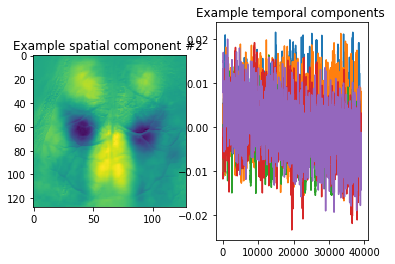

In [10]:
# plot example spatial and temporal components
ax=plt.subplot(121)
plt.imshow(U[:,:,2])
plt.title("Example spatial component #2 ")
ax=plt.subplot(122)
plt.title("Example temporal components ")
plt.plot(V[:5].T)
plt.show()

(128, 128)


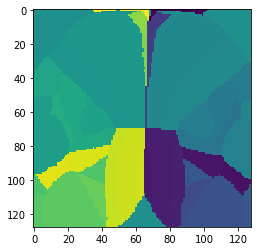

In [11]:
# Get region based Allen map
#dorsalMapScaled = sio.loadmat(datafolder+'allenDorsalMap.mat')['dorsalMapScaled']
#dorsalMapScaled = sio.loadmat('/home/cat/Downloads/locaNMF/locaNMF/data/AllenMap/preprocessed_allenDorsalMap.mat')['dorsalMapScaled']
#print (dorsalMapScaled.shape)
data = sio.loadmat(data_folder+'/warped_atlas.mat')
dorsalMapScaled = data['atlas']

#dorsalMapScaled = np.resize(dorsalMapScaled,128,128)
#dorsalMapScaled = sio.loadmat('/media/cat/10TB/in_vivo/tim/yuki/IA2/tif_files/IA2pm_Feb1_30Hz/warped_atlas.mat')['dorsalMapScaled']

print (dorsalMapScaled.shape)
plt.imshow(dorsalMapScaled); plt.show()
#dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] = dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] * -1
#dorsalMapScaled = dorsalMapScaled[:new_y, :new_x]

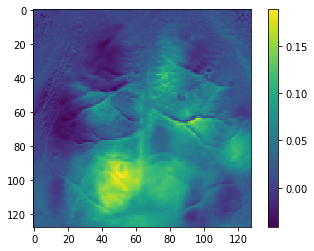

In [69]:
# Plot example frame
frame1=np.matmul(U,V[:,4]); plt.imshow(frame1); plt.colorbar(); plt.show()

In [70]:
# If brainmask does not exactly align with mask applied to data
# Umasked=U; 
# Umasked[~brainmask]=np.nan; 
# plt.imshow(Umasked[:,:,0]); 
# plt.colorbar(); 
# plt.show()

# Umasked=np.reshape(Umasked,(128*128,500))
# maskout=np.where(np.all(Umasked==0,axis=1))[0]

# brainmask=np.reshape(brainmask,(128*128)); 
# brainmask[maskout]=0; 
# brainmask=np.reshape(brainmask,(128,128))


# Umasked=U; 
# Umasked[~brainmask]=np.nan; 
# plt.imshow(Umasked[:,:,0]); 
# plt.colorbar(); 
# plt.show()

In [71]:
# Perform the LQ decomposition. Time everything.
t0_global = time.time()
t0 = time.time()
q, r = np.linalg.qr(V.T)
time_ests={'qr_decomp':time.time() - t0}

# Initialize LocaNMF

In [72]:
# Put in data structure for LocaNMF
video_mats = (np.copy(U[brainmask]), r.T)
# del U

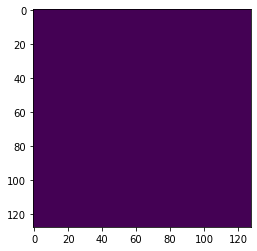

True


In [73]:
valid_mask = brainmask
region_map = dorsalMapScaled
plt.imshow(valid_mask); plt.show()
print(brainmask[0,0])

In [74]:
# region_mats[0] = [unique regions x pixels] the mask of each region
# region_mats[1] = [unique regions x pixels] the distance penalty of each region
# region_mats[2] = [unique regions] area code
region_mats = LocaNMF.extract_region_metadata(valid_mask,
                                              region_map,
                                              min_size=rank_range[1])

In [75]:
region_metadata = LocaNMF.RegionMetadata(region_mats[0].shape[0],
                                       region_mats[0].shape[1:],
                                       device=device)

In [76]:
region_metadata.set(torch.from_numpy(region_mats[0].astype(np.uint8)),
                    torch.from_numpy(region_mats[1]),
                    torch.from_numpy(region_mats[2].astype(np.int64)))

In [77]:
# Do SVD
if device=='cuda': torch.cuda.synchronize()
print('v SVD Initialization')
t0 = time.time()
region_videos = LocaNMF.factor_region_videos(video_mats,
                                           region_mats[0],
                                           rank_range[1],
                                           device=device)
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['svd_init'] = time.time() - t0

v SVD Initialization
'-total : 0.134647


In [78]:
low_rank_video = LocaNMF.LowRankVideo(
    (int(np.sum(valid_mask)),) + video_mats[1].shape, device=device
)
low_rank_video.set(torch.from_numpy(video_mats[0].T),
                   torch.from_numpy(video_mats[1]))

# Do LocaNMF

In [79]:
if device=='cuda': torch.cuda.synchronize()
print('v Rank Line Search')
t0 = time.time()
print (maxrank, minrank)
debug = LocaNMF.rank_linesearch(low_rank_video,
                              region_metadata,
                              region_videos,
                              maxiter_rank=maxrank-minrank+1,
                              maxiter_lambda=400, #maxiter_lambda=1, 
                              maxiter_hals=20,
                              lambda_step=1.35,
                              lambda_init=1e-19, #lambda_init=0, 
                              loc_thresh=loc_thresh,
                              r2_thresh=r2_thresh,
                              rank_range=rank_range,
                              verbose=[True, False, False],
                              sample_prop=(1,1),
                              device=device
                             )
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['rank_linesearch'] = time.time() - t0

v Rank Line Search
4 1
|--v Rank Line Search Iteration 0
|  |--v Initialization
|  |  '-total : 0.005058 seconds
|  |--v Lambda Line Search
Removing components, num remaining: 58
Removing components, num remaining: 57
|  |  '- 345 iterations took 364.693 seconds
|  |--> R2 Evaluation took 0.20256 seconds
|  '-total : 364.901 seconds
|--v Rank Line Search Iteration 1
|  |--v Initialization
|  |  '-total : 0.144012 seconds
|  |--v Lambda Line Search
Removing components, num remaining: 88
|  |  '- 311 iterations took 413.682 seconds
|  |--> R2 Evaluation took 0.205098 seconds
|  '-total : 414.031 seconds
|--v Rank Line Search Iteration 2
|  |--v Initialization
|  |  '-total : 0.041302 seconds
|  |--v Lambda Line Search
|  |  '- 317 iterations took 450.509 seconds
|  |--> R2 Evaluation took 0.20649 seconds
|  '-total : 450.757 seconds
|--v Rank Line Search Iteration 3
|  |--v Initialization
|  |  '-total : 0.030671 seconds
|  |--v Lambda Line Search
Removing components, num remaining: 100


In [80]:
print("Number of components : %f" % len(debug))

Number of components : 100.000000


In [81]:
# Evaluate R^2
_,r2_fit=LocaNMF.evaluate_fit_to_region(low_rank_video,debug,region_metadata.support.data.sum(0),sample_prop=(1, 1))
print("R^2 fit on all data : %f" % r2_fit)
time_ests['global_time'] = time.time()-t0_global


R^2 fit on all data : 0.997309


In [95]:
# Assigning regions to components
region_ranks = []; region_idx = []
for rdx in torch.unique(debug.regions.data, sorted=True):
    region_ranks.append(torch.sum(rdx == debug.regions.data).item())
    region_idx.append(rdx.item())
print(len(region_ranks))
areas=np.repeat(region_mats[2],region_ranks,axis=0)

36


ValueError: operands could not be broadcast together with shape (59,) (36,)

In [83]:
# Get LocaNMF spatial and temporal components, with A normalized to be <= 1
A=debug.spatial.data.cpu().numpy().T
max_A=np.zeros(A.shape[1])
for i in np.arange(A.shape[1]):
    max_A[i]=np.max(A[:,i])
    A[:,i]=A[:,i]/max_A[i]
A_reshape=np.zeros((brainmask.shape[0],brainmask.shape[1],A.shape[1])); A_reshape.fill(np.nan)
A_reshape[brainmask,:]=A

C=np.matmul(q,debug.temporal.data.cpu().numpy().T).T
for i in np.arange(C.shape[0]):
    C[i,:]=C[i,:]*max_A[i]


# Plotting Components and Lambdas

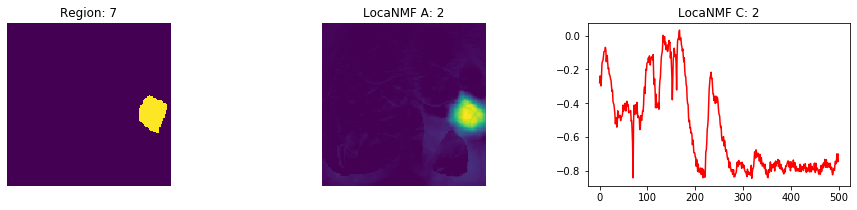

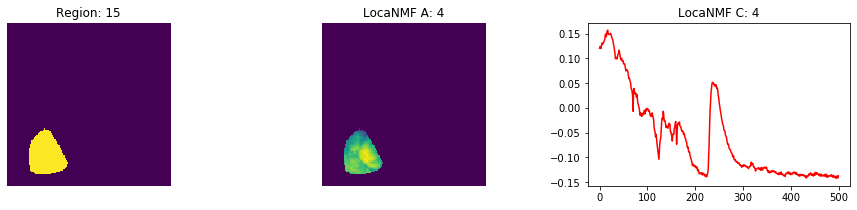

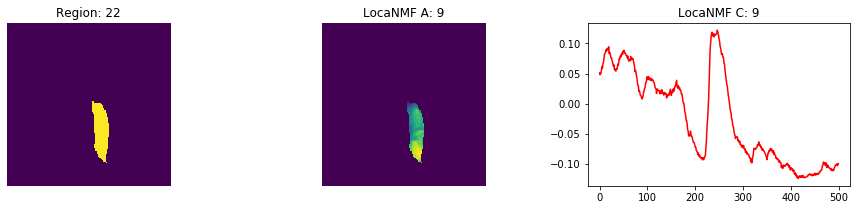

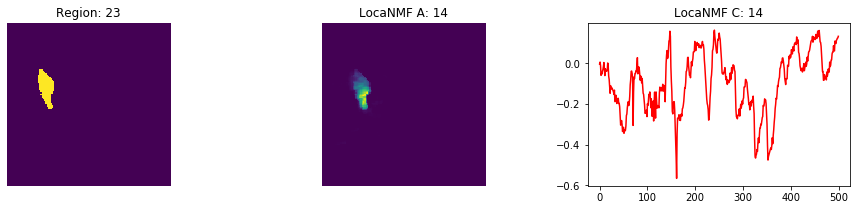

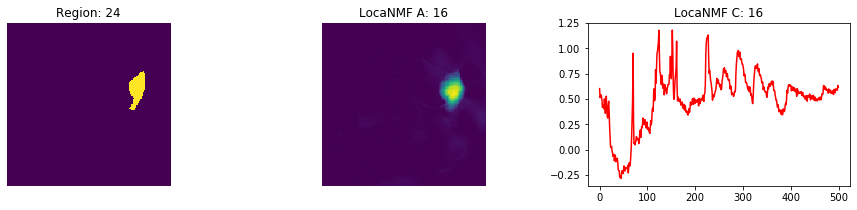

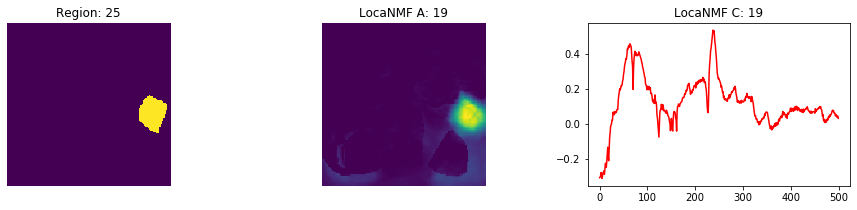

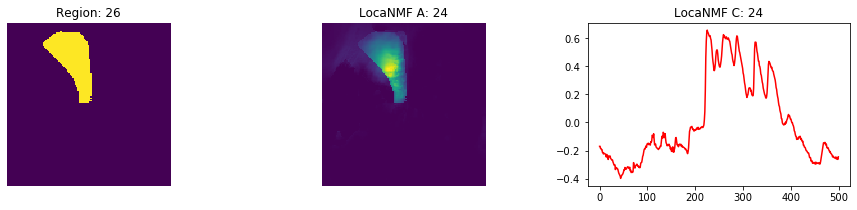

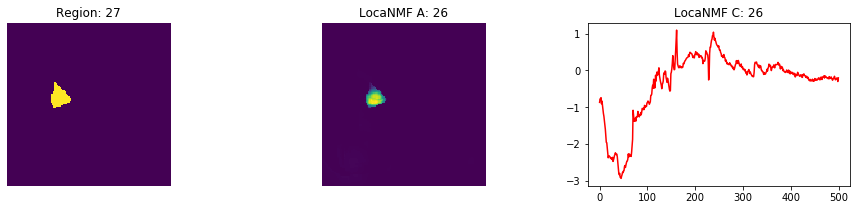

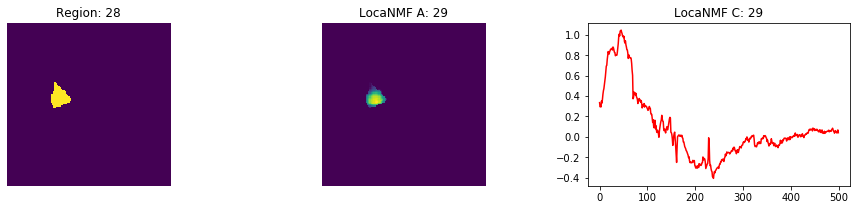

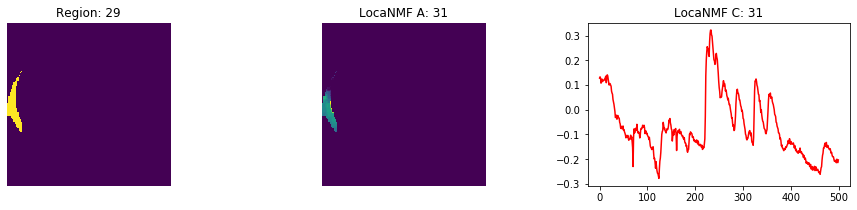

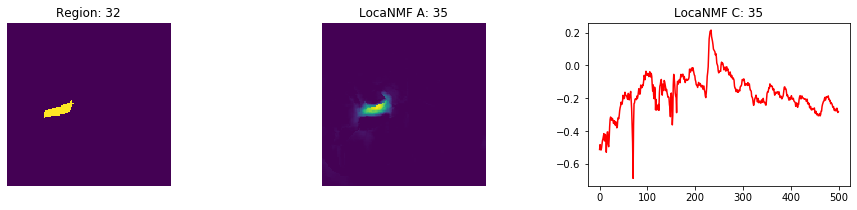

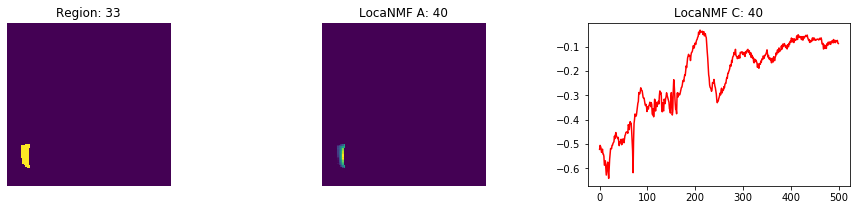

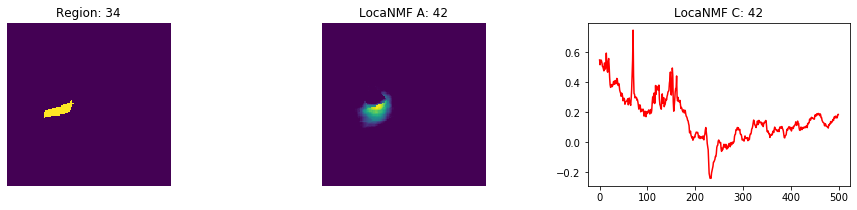

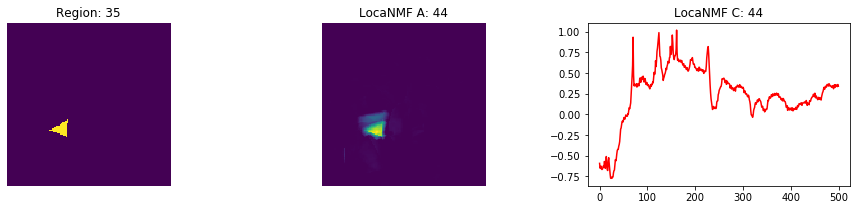

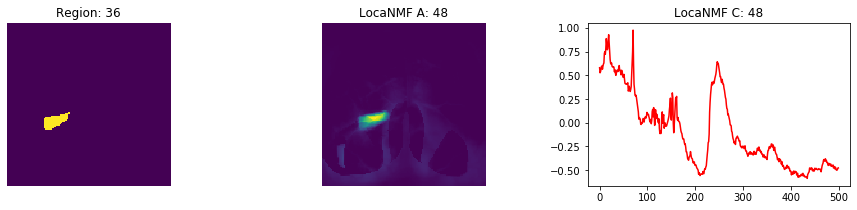

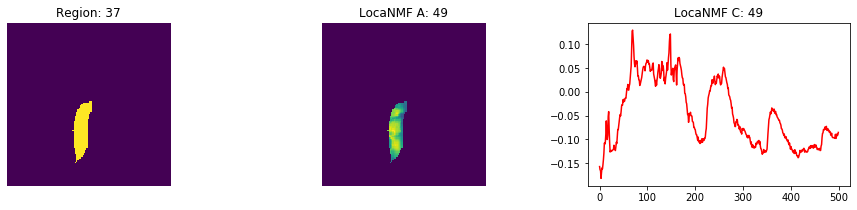

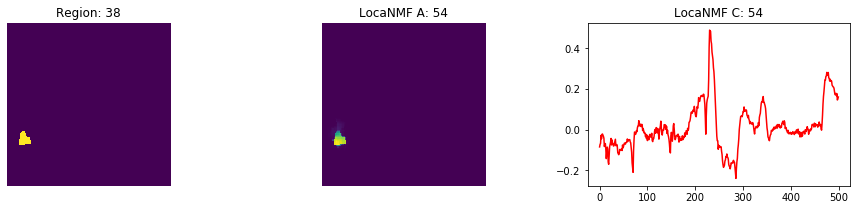

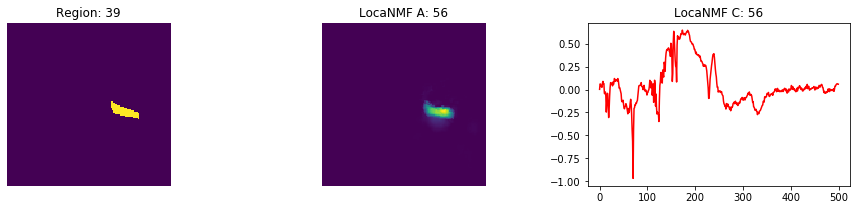

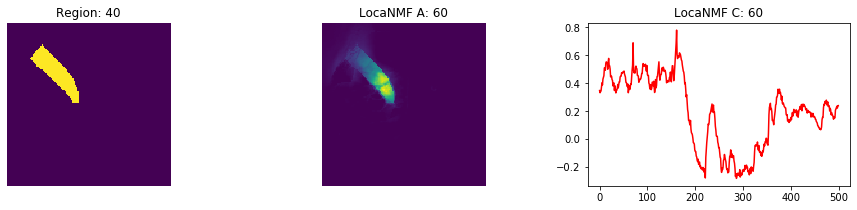

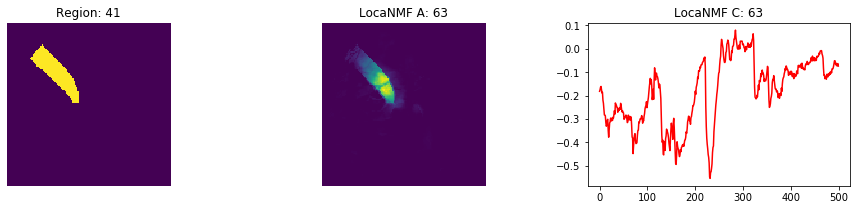

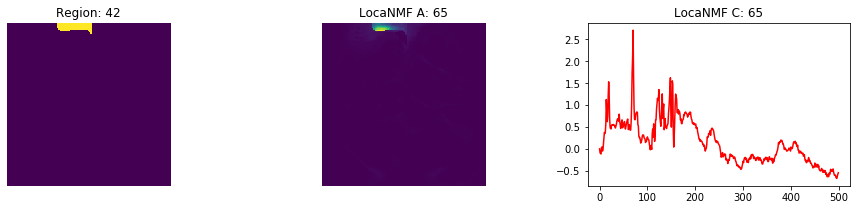

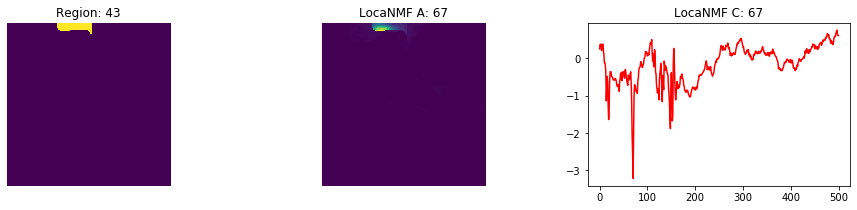

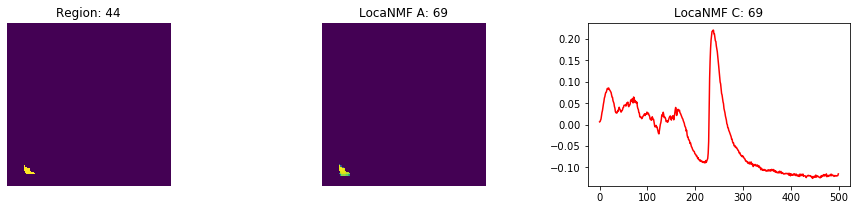

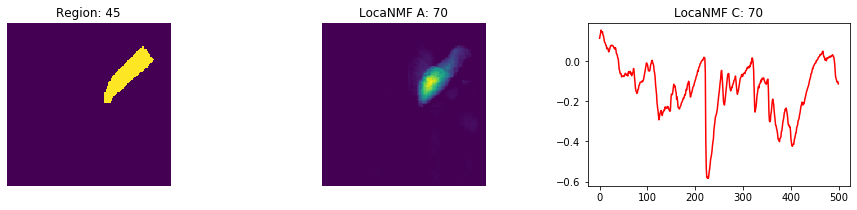

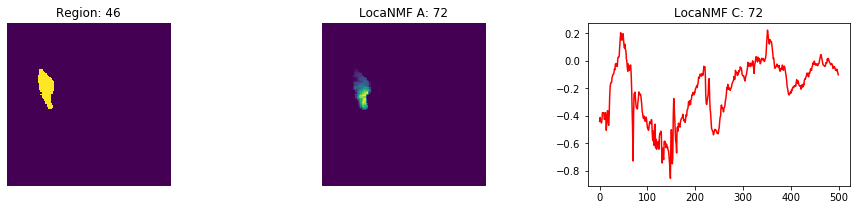

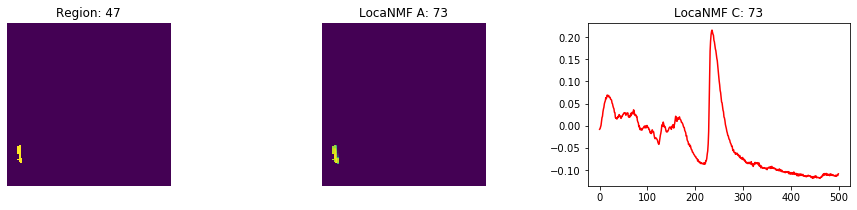

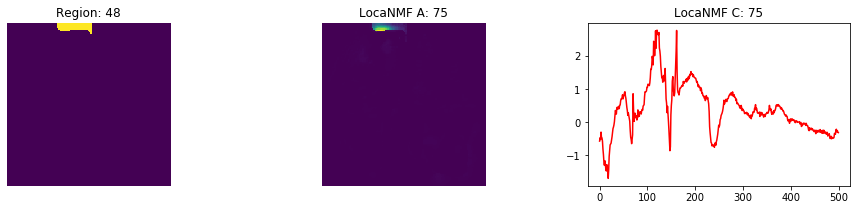

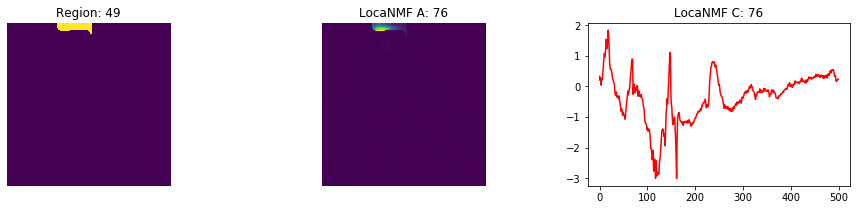

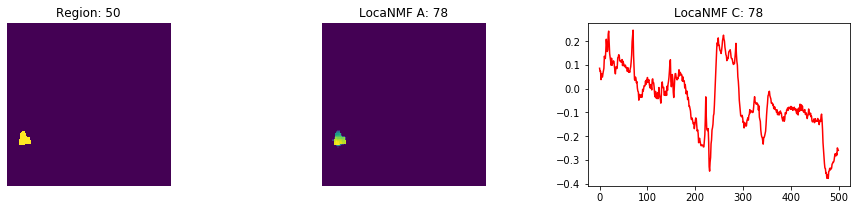

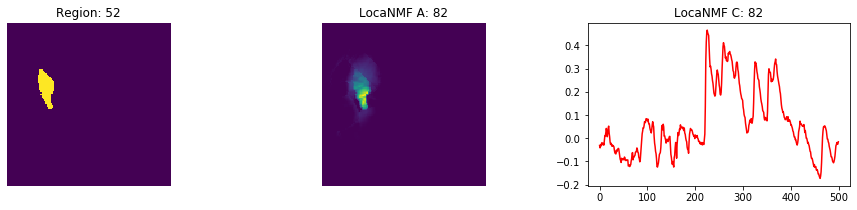

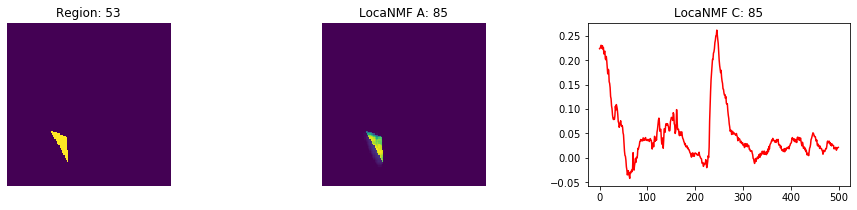

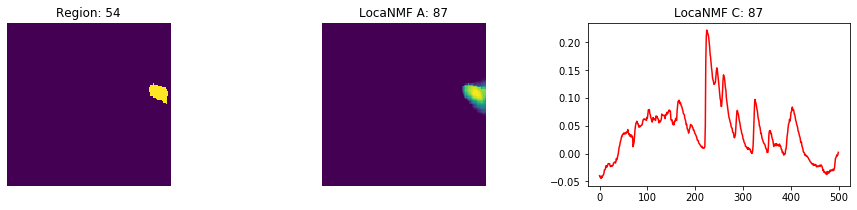

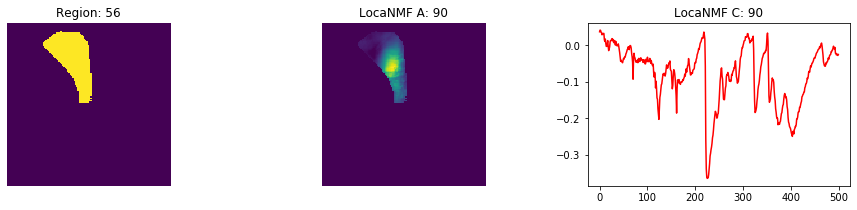

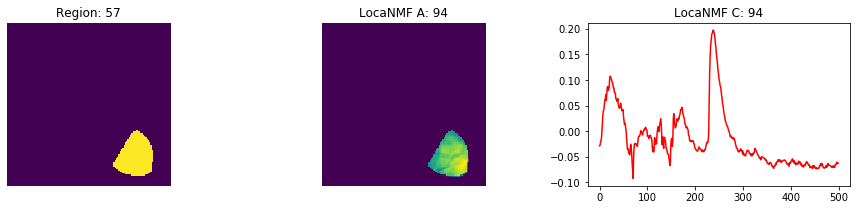

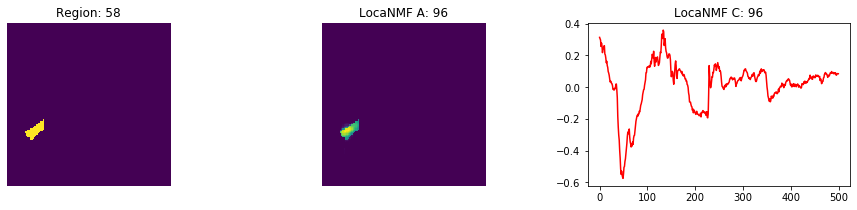

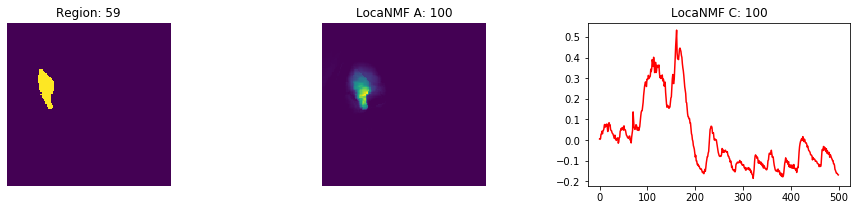

In [84]:
# Plotting all the regions' components
A_validmask=np.zeros((brainmask.shape[0],brainmask.shape[1])); A_validmask.fill(np.nan)

for rdx, i in zip(region_idx, np.cumsum(region_ranks)-1):
    fig, axs = plt.subplots(1, 3,figsize=(16,3))
    axs = axs.reshape((int(np.prod(axs.shape)),))
    A_validmask[brainmask] = debug.distance.data[i].cpu()==0
    axs[0].imshow(A_validmask)
    axs[0].set_title("Region: {}".format(rdx+1)); axs[0].axis('off')
        
    axs[1].imshow(A_reshape[:,:,i])
    axs[1].set_title("LocaNMF A: {}".format(i+1)); axs[1].axis('off')
    
    axs[2].plot(C[i,:500].T,'r');
    axs[2].set_title("LocaNMF C: {}".format(i+1)); #axs[2].axis('off'); 
    #
    plt.show()

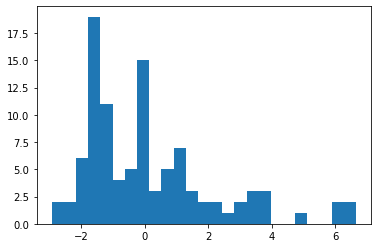

In [85]:
# Plot the distribution of lambdas. 
# If lots of values close to the minimum, decrease lambda_init.
# If lots of values close to the maximum, increase maxiter_lambda or lambda_step.
plt.hist(np.log(debug.lambdas.data.cpu()), bins=torch.unique(debug.lambdas.data).shape[0])
plt.show()

# Reformat spatial and temporal matrices, and save

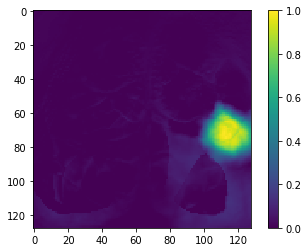

In [86]:
# Plot an example component
plt.imshow(A_reshape[:,:,1]); plt.colorbar(); plt.show()

In [87]:
print (A_reshape.shape)

(128, 128, 100)


In [98]:
sio.savemat(data_folder+'locanmf_decomp_loc'+str(loc_thresh)+'.mat',
            {'C':C,
             'A':A_reshape,
             'lambdas':debug.lambdas.data.cpu().numpy(),
             'r2_fit':r2_fit,
             'time_ests':time_ests
            })

In [26]:
torch.cuda.empty_cache()